# Decision Tree Model for mit data 
As we concluded before, for PTB data, we apply the following preprocessing:   
resampling: oversampling   
rescaling: minmax     

If you don't have the original files: run the notebook  `preprocessing_mit_minmax_oversampling.ipynb`
Input file:(The preprocessed data)      
mit_train_clean_standard_oversampling.csv  
mit_test_clean_standard_oversampling.csv     

Output: Decision Tree model trained  
model_mit_decision_tree.pkl  

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: /Users/pingyuan/Documents/codeself/heartbeat-analysis-ai/notebooks


## Read data 


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns


RawFiles = dict({
    'train': data_path + 'mitbih_train_clean_minmax_oversampling.csv', 
    'test': data_path + 'mitbih_test_clean_minmax_oversampling.csv'  
})


OutputFiles = dict({
    'model': model_output_path +  'model_mit_decision_tree.pkl'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)

## Grid Search for optimized Decision Tree model with MinMax Scaled and oversampled data.

Decision Tree Best parameters: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Decision Tree Best score: 0.9886637730257728
Decision Tree F1 score: 0.8380642159143787


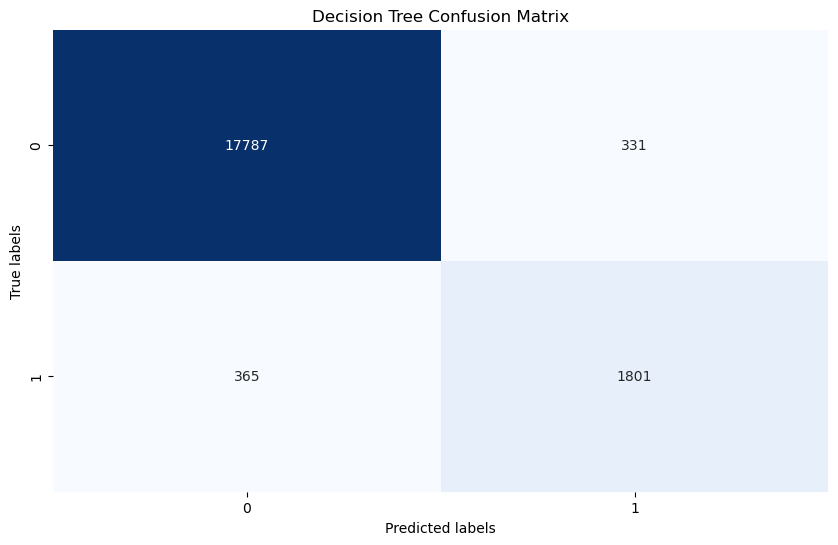

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     18118
           1       0.84      0.83      0.84      2166

    accuracy                           0.97     20284
   macro avg       0.91      0.91      0.91     20284
weighted avg       0.97      0.97      0.97     20284



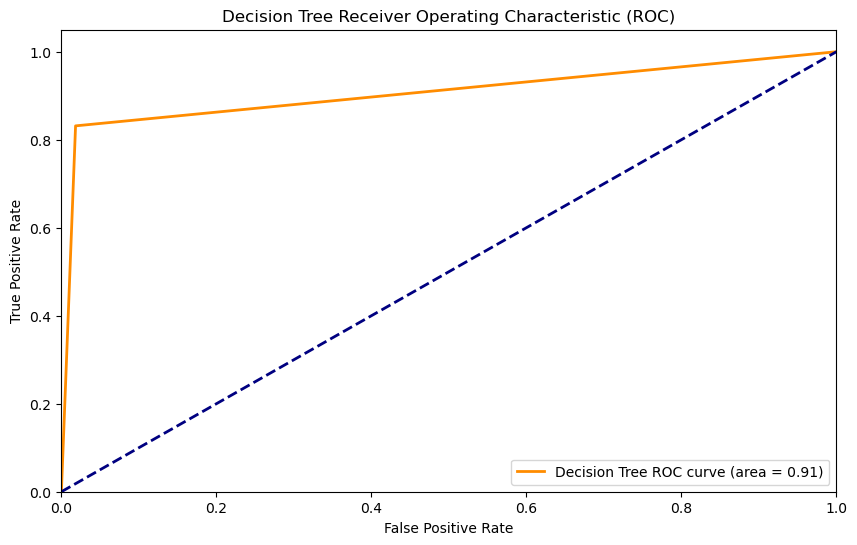

In [3]:
# Define Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)

# Grid parameters for Decision Tree
tree_grid_params = {
    'model__criterion': ['gini', 'entropy'], # Splitting criterion for Decision Tree: Gini means Gini impurity and Entropy means information gain
    'model__max_depth': [None, 10, 20, 30], # Maximum depth of the Decision Tree
    'model__min_samples_split': [2, 5, 10], #   Minimum number of samples required to split an internal node in Decision Tree   
    'model__min_samples_leaf': [1, 2, 4] # Minimum number of samples required to be at a leaf node in Decision Tree
}

# Create a pipeline that includes Decision Tree (no scaling)
pipeline = Pipeline([
    ('model', tree_model)
])

# Initialize GridSearchCV
tree_grid_search = GridSearchCV(pipeline, tree_grid_params, cv=5, scoring='f1', n_jobs=-1)

try:
    # Fit the Decision Tree grid search on the training data
    tree_grid_search.fit(X_train, y_train)
    
    # Get the best parameters and model for Decision Tree
    tree_best_params = tree_grid_search.best_params_
    print("Decision Tree Best parameters:", tree_best_params)

    tree_best_score = tree_grid_search.best_score_
    print("Decision Tree Best score:", tree_best_score)

    tree_best_model = tree_grid_search.best_estimator_

    # Predict and evaluate Decision Tree on test data using the pipeline
    y_pred_tree = tree_best_model.predict(X_test)
    f1_tree = f1_score(y_test, y_pred_tree)
    print("Decision Tree F1 score:", f1_tree)

    # Generate and plot confusion matrix
    conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Decision Tree Confusion Matrix')
    plt.show()

    # Generate and print classification report
    class_report_tree = classification_report(y_test, y_pred_tree)
    print("Decision Tree Classification Report:\n", class_report_tree)

    # ROC curve and AUC for binary classification
    if len(np.unique(y_test)) == 2:  # Ensure binary classification
        y_prob_tree = tree_best_model.predict_proba(X_test)[:, 1]
        fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
        roc_auc_tree = auc(fpr_tree, tpr_tree)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=2, label='Decision Tree ROC curve (area = %0.2f)' % roc_auc_tree)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Decision Tree Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("ROC curve is only applicable for binary classification in Decision Tree.")
    
except ValueError as e:
    print(f"Error during GridSearchCV: {e}")


# Save Best Decision Tree Model

In [5]:
from sklearn.metrics import f1_score
y_pred = tree_best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)

F1 Score: 0.8380642159143787


In [4]:
# Save model 
import pickle
# Save the model to a file
with open(OutputFiles.get('model'), 'wb') as model_file:
    pickle.dump(tree_best_model, model_file)

In [5]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-11-13 17:19:49.630270
